In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [260]:
path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/seg_prueba'

In [261]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [262]:
pixels = 256

In [263]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [264]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [265]:
def binarize(img):
    img[img>0] = 1
    return img

In [266]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [267]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(path, 'images', masks_name[i]))

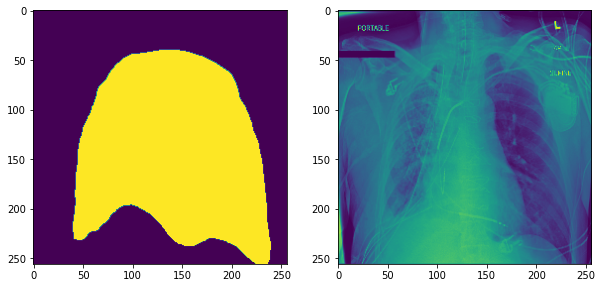

In [299]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [300]:
images.shape

(80, 256, 256, 1)

## Selección de pesos por imagen

Vamos a ver las imagenes y elegir las de peor calidad para darles más peso

0


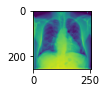

1


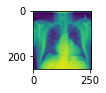

2


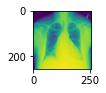

3


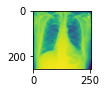

4


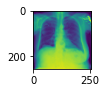

5


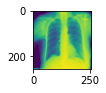

6


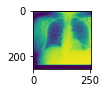

7


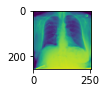

8


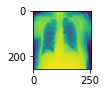

9


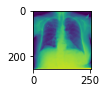

10


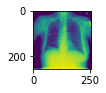

11


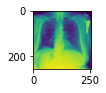

12


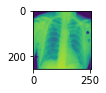

13


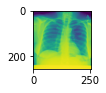

14


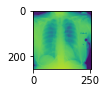

15


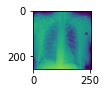

16


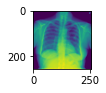

17


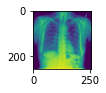

18


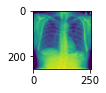

19


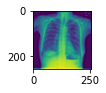

20


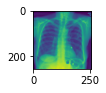

21


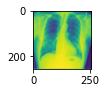

22


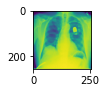

23


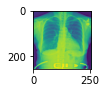

24


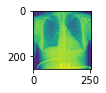

25


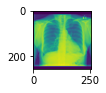

26


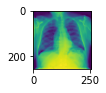

27


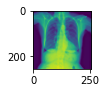

28


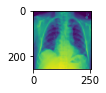

29


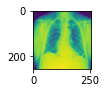

30


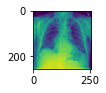

31


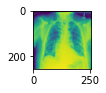

32


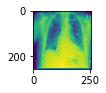

33


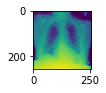

34


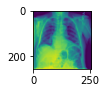

35


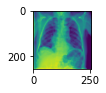

36


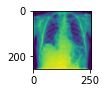

37


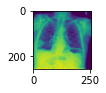

38


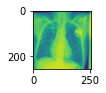

39


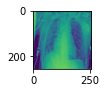

40


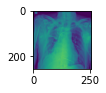

41


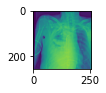

42


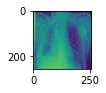

43


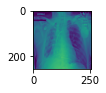

44


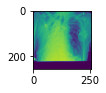

45


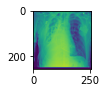

46


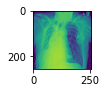

47


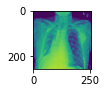

48


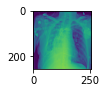

49


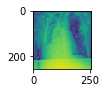

50


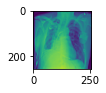

51


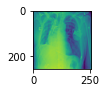

52


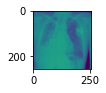

53


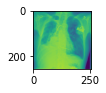

54


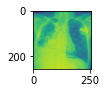

55


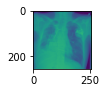

56


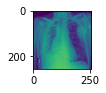

In [ ]:
for i in range(len(images)):
    print(i)
    plt.figure(figsize=(100, 100))
    plt.subplot(1,len(images),i+1)
    plt.imshow(images[i])
    plt.show()

In [288]:
bad_quality = [14,15,34] + [i for i in range(39,56)] + [65,73,76,77]

In [297]:
importance = [1 if i in bad_quality else 0.75 for i in range(len(images))]

(80, 256, 256, 1)

# Aumento de datos

In [70]:
import imutils

In [71]:
def augment(input_image, input_mask):
    r = np.random.randint(-60,60)
    # Random flipping of the image and mask
    input_image = np.expand_dims(imutils.rotate(input_image, angle=r),  axis=-1)
    input_mask = np.expand_dims(imutils.rotate(input_mask, angle=r), axis=-1)
    return input_image, input_mask

Nuevas imagenes con rotacion random

In [110]:
new_img = np.zeros((len(masks_name), pixels,pixels,1))
new_mask = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    img, mask = augment(images[i], masks[i])
    new_img[i, ...] = img
    new_mask[i,...] = mask

In [111]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)

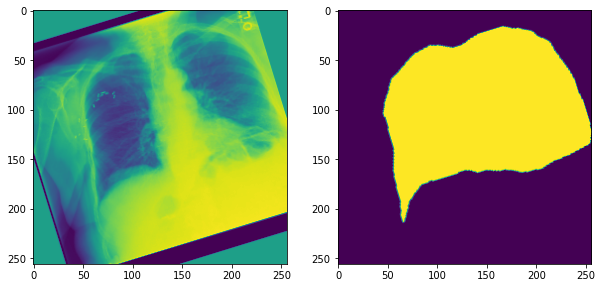

In [129]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()

In [112]:
images.shape

(160, 256, 256, 1)

In [113]:
masks.shape

(160, 256, 256, 1)

# U-Net

In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [131]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [132]:
def double_conv_block(x, n_filters):
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with eLU activation
    x = double_conv_block(x, n_filters)
    return x

In [133]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(pixels,pixels,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [134]:
unet_model = build_unet_model()

In [135]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_20[0][0]                  
______________________________________________________________________________________________

In [136]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

In [137]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(images)

In [138]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [139]:
batch = 8
epoch = 500

In [140]:
history = unet_model.fit(images,masks,
                        batch_size = batch,
                        epochs = epoch,
                        callbacks = tensorboard_callback,
                        shuffle = True,
                        validation_split = 0.2)

Epoch 1/500
16/16 [==============================] - 7s 346ms/step - loss: 2.4413 - accuracy: 0.4866 - val_loss: 0.7108 - val_accuracy: 0.5696
Epoch 2/500
16/16 [==============================] - 5s 306ms/step - loss: 0.6948 - accuracy: 0.6062 - val_loss: 0.5677 - val_accuracy: 0.6815
Epoch 3/500
16/16 [==============================] - 5s 304ms/step - loss: 0.6821 - accuracy: 0.6534 - val_loss: 0.6669 - val_accuracy: 0.6260
Epoch 4/500
16/16 [==============================] - 5s 306ms/step - loss: 0.6926 - accuracy: 0.6129 - val_loss: 0.6569 - val_accuracy: 0.5990
Epoch 5/500
16/16 [==============================] - 5s 309ms/step - loss: 0.6406 - accuracy: 0.6342 - val_loss: 0.7131 - val_accuracy: 0.6780
Epoch 6/500
16/16 [==============================] - 5s 309ms/step - loss: 0.5883 - accuracy: 0.7126 - val_loss: 0.5050 - val_accuracy: 0.7524
Epoch 7/500
16/16 [==============================] - 5s 311ms/step - loss: 0.5889 - accuracy: 0.6832 - val_loss: 0.7929 - val_accuracy: 0.5934

KeyboardInterrupt: 

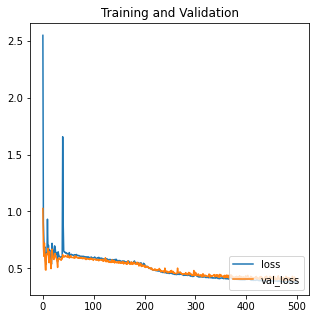

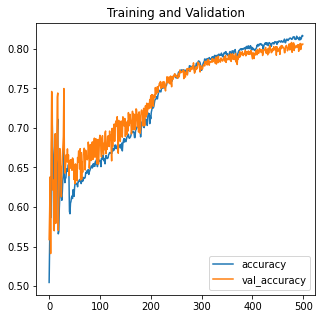

In [141]:
epochs_range = range(epoch)
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(epochs_range, history.history[key], label=key)
    plt.plot(epochs_range, history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()

In [148]:
path = '/home/mr1142/Documents/Data/NIH/images_005'

In [149]:
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

In [235]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict(img[np.newaxis,...])

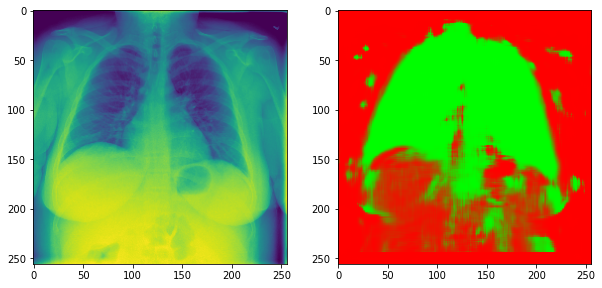

In [236]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask[0,...])
plt.show()